In [24]:
import numpy as np
import random
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from tqdm import tqdm
import math

In [166]:
import wandb

wandb.login()

True

In [25]:
sweep_config = {
    'method': 'bayes'
    }

In [26]:
metric = {
    'name': 'valAcc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

In [27]:
parameters_dict = {
    'optimizer': {
        'values': ['nadam', 'momentum', 'nag', 'rmsprop', 'adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [32, 64, 128]
        },
    'number_of_layers': {
        'values' : [3,4,5]
        },
    'epochs':{
        'values' : [5,10]
        },
    'decay' : {
        'values' : [0 ,0.0005, 0.5]
        },
    'learningRate' : {
        'values' : [1e-3, 1e-4]
        },
    'batchSize' : {
        'values' : [16, 32, 64]
        },
    'initialization' : {
        'values' : ['random', 'Xavier']
        },
    'activation' : {
        'values' : ['sigmoid', 'tanh', 'relu']
        },
    }

sweep_config['parameters'] = parameters_dict

In [28]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'valAcc'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'relu']},
                'batchSize': {'values': [16, 32, 64]},
                'decay': {'values': [0, 0.0005, 0.5]},
                'epochs': {'values': [5, 10]},
                'fc_layer_size': {'values': [32, 64, 128]},
                'initialization': {'values': ['random', 'Xavier']},
                'learningRate': {'values': [0.001, 0.0001]},
                'number_of_layers': {'values': [3, 4, 5]},
                'optimizer': {'values': ['nadam',
                                         'momentum',
                                         'nag',
                                         'rmsprop',
                                         'adam',
                                         'sgd']}}}


In [172]:
sweep_id = wandb.sweep(sweep_config, project="test2")

Create sweep with ID: uzzqn91g
Sweep URL: https://wandb.ai/cs22m028/test2/sweeps/uzzqn91g


In [173]:
def train(config = None):
    
    with wandb.init(config = config):
        #pprint.pprint(sweep_config)        
        config = wandb.config
        neuralNet = FFNet(0, len(trainx[0]), 10)
        for layer in range(config.number_of_layers):
            neuralNet.addHiddenLayer(config.fc_layer_size, config.initialization)
        neuralNet.addOutputLayer(10, config.initialization)
        neuralNet.solidify()
        weights, biases = neuralNet.fit(config.optimizer,config.batchSize, config.learningRate, config.activation, trainx, train_y, config.decay, config.epochs)
        print(Algorithms.evaluateNetwork(weights,biases,testx, test_y))  

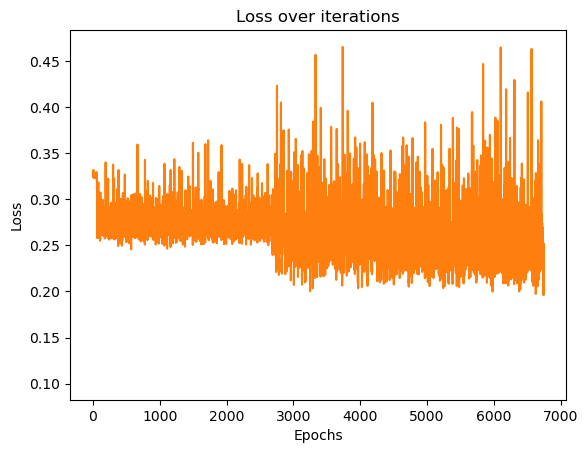

 90%|███████████████████████████████████████▌    | 9/10 [01:36<00:10, 10.64s/it]

In [16]:
def train(config = None):
    
    with wandb.init(config = config):
        #pprint.pprint(sweep_config)        
        config = wandb.config
        neuralNet = FFNet(0, len(trainx[0]), 10)
        for layer in range(config.number_of_layers):
            neuralNet.addHiddenLayer(config.fc_layer_size, config.initialization)
        neuralNet.addOutputLayer(10, config.initialization)
        neuralNet.solidify()
        config.optimizer = "relu"
        weights, biases = neuralNet.fit(config.optimizer,config.batchSize, config.learningRate, config.activation, trainx, train_y, config.decay, config.epochs)
        print(Algorithms.evaluateNetwork(weights,biases,testx, test_y))  

In [ ]:
wandb.agent(sweep_id, train, count=5)

In [48]:
class PreProc:
    def __init__(self):
        (self.trainx,self.trainy),(self.testx, self.testy) = fashion_mnist.load_data()
        
    def visualize(self,n):
        for i in range(n):
            plt.subplot(330+1+i) # ask someone why??
            plt.imshow(self.trainx[i], cmap = plt.get_cmap('gray'))
        plt.show()
        
    def flattenAndCentralize(self):
        trainx_flattened = np.copy(self.trainx).astype('float64')
        testx_flattened = np.copy(self.testx).astype('float64')
        trainx_flattened -= np.mean(trainx_flattened, axis = 0)
        testx_flattened -= np.mean(testx_flattened, axis = 0)
        trainx_flattened.shape = (60000,784)
        testx_flattened.shape = (10000,784)
        return trainx_flattened,testx_flattened
    

    
    def getLabels(self):
        return self.trainy, self.testy
    
    def getInputSize(self):
        return len(self.trainx[0])

In [3]:
import sys

In [5]:
class Functions:
    @staticmethod
    def sigmoid(input):
        input = np.clip(input, -100,100)
        return  1.0/(1.0+np.exp(-input))
    
    @staticmethod
    def reLU(input):
        return np.maximum(0.01*input,input)
    
    @staticmethod
    def tanh(input):
        return np.tanh(input)
    
    @staticmethod
    def identity(input):
        return input
    
    @staticmethod
    def softmax(input):
        input = np.clip(input, -100,100)
        return np.exp(input)/(np.sum(np.exp(input)))
    
    @staticmethod
    def onehot(input):
        result = np.zeros(10)
        result[input] = 1
        return result
    
    @staticmethod
    def crossEntropyLoss(y,yHat):
        loss = (-1/10.0) * np.sum(np.multiply(y, np.log(yHat+1e-10)) + np.multiply((1 - y), np.log(1 - (yHat+1e-10))))
        return loss
    
    @staticmethod
    def derivative_sigmoid(input):
        return Functions.sigmoid(input)*(1-Functions.sigmoid(input))
    
    @staticmethod
    def derivative_tanh(input):
        return (1 - (np.tanh(input)**2))
    
    @staticmethod
    def derivative_reLU(input):
        return np.where(input > 0, 1, 0.01)

    
    @staticmethod
    def derivative_identity(input):
        return 1
    
    @staticmethod
    def plot(input):
        plt.plot(input)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over iterations")

In [96]:
class Algorithms:
    @staticmethod
    def ForwardProp(weights, bias, activate, output, inputLayer):
        L = len(weights)-1
        a = []
        h = []
        a.append(np.matmul(weights[0],inputLayer)+bias[0])
        h.append(activate(a[0]))
        for k in range(1,L):
            a.append(np.matmul(weights[k],h[k-1].T)+bias[k])
            h.append(activate(a[k]))
        a.append(np.matmul(weights[L],h[L-1].T)+bias[L])
        h.append(output(a[L]))
        return a,h
    @staticmethod
    def BackProp(weights, biases, a, h, derivative, dataPoint, dataLabel):
        L = len(weights)-1
        gradaL = -(Functions.onehot(dataLabel)-h[len(h)-1])
        dw = np.zeros_like(weights)
        db = np.zeros_like(biases)
        for k in range(L,0,-1):
            gradW = np.outer(gradaL, h[k-1].T)
            gradB = gradaL
            dw[k] = gradW
            db[k] = gradB

            gradhL_1 = np.matmul(np.transpose(weights[k]),gradaL)
            gradaL_1 = np.multiply(gradhL_1, derivative(a[k-1]))
            gradaL = gradaL_1
        dw[0] = np.outer(gradaL,dataPoint.T)
        db[0] = gradaL
        return dw, db

    @staticmethod
    def miniBatchMGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        lossTrack = []
        LOSS = 0.0
        validation = []
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = prevWeights*beta + dw*1.0
                momentumBiases = prevBiases*beta + db*1.0
                weights -= learningRate*(momentumWeights + decay*weights)
                biases -= learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
                
            wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            #print("The val_acc after this epoch is: "+ str(validation))
        #Functions.plot(validation)
        return weights, biases

    @staticmethod
    def ADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        validation = []
        prev_val = 0.0
        lossTrack = []
        beta1 = 0.9
        beta2 = 0.99
        epsilon = 0.000001
        patience = 3
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases,activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(v_w_hat[i])
                    tempB[i] = np.sqrt(v_b_hat[i])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)

                lossTrack.append(batchLoss)
            
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch})
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            if validation[-1] <= prev_val+1e-2:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience == 0:
                #print("decreasing learning rate in "+ str(epoch))
                #learningRate *= 1.5
                weights = prev_weights
                biases = prev_biases
            #print("The val_acc after this epoch is: "+ str(validation))
        #Functions.plot(validation)
        if prev_val > validation[-1]:
            return prev_weights, prev_biases
            #print("The loss after this epoch is: "+ str(batchLoss))
        return weights,biases

    @staticmethod
    def NADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        patience = 3
        lossTrack = []
        validation = []
        prev_val = 0.0
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        beta1 = 0.9
        beta2 = 0.99
        epsilon = 0.000001
        prev_weights = np.zeros_like(weights)
        prev_biases = np.zeros_like(biases)
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights - v_w*(beta1), biases - v_b*(beta1), activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights - v_w*(beta1), biases - v_b*(beta1), a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for j in range(len(dw)):
                    tempW[j] = np.sqrt(v_w_hat[j])
                    tempB[j] = np.sqrt(v_b_hat[j])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch})
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            if validation[-1] <= prev_val:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience <= 0:
                weights = prev_weights
                biases = prev_biases
                #learningRate /= 2
            wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            #print("The val_acc after this epoch is: "+ str(validation))
        #Functions.plot(validation)
            #print("The loss after this epoch is: "+ str(batchLoss))
        return prev_weights, prev_biases

    
    @staticmethod
    def miniBatchNAG(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        lossTrack = []
        validation = []
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                tempWeights = np.zeros_like(weights)
                tempBiases = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights-prevWeights, biases-prevBiases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights-prevWeights, biases-prevBiases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    tempWeights += currWeights
                    tempBiases += currBiases
                batchLoss /= batchSize
                tempWeights /= batchSize
                tempBiases /= batchSize
                momentumWeights = beta*prevWeights + tempWeights*1.0
                momentumBiases = beta*prevBiases + tempBiases*1.0
                weights = weights - learningRate*(momentumWeights + decay*weights) 
                biases = biases - learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
            wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch})
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            #print("The val_acc after this epoch is: "+ str(validation))
            #Functions.plot(validation)
            #print("The loss after this epoch is: "+ str(batchLoss))
            #Functions.plot(lossTrack)
        return net
    
    @staticmethod
    def RMSProp(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        lossTrack = []
        validation = []
        beta = 0.5
        epsilon = 0.000001
        momentumWeights = np.zeros_like(weights)
        momentumBiases = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = momentumWeights*beta + (1-beta)*dw**2
                momentumBiases = momentumBiases*beta + (1-beta)*db**2
                tempW = np.zeros_like(momentumWeights)
                tempB = np.zeros_like(momentumBiases)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(momentumWeights[i])
                    tempB[i] = np.sqrt(momentumBiases[i])
                weights = weights - ((learnerRateW)*(dw + decay*weights)/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch})
            validation.append(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y))
            #print("The val_acc after this epoch is: "+ str(validation))
            #Functions.plot(validation)
            #print("The loss after this epoch is: "+ str(batchLoss))
        return weights, biases

    @staticmethod
    def miniBatchGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        validation = []
        lossTrack = []
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    tempw,tempb = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    dw+=tempw
                    db+=tempb
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                weights -= learningRate*(dw + decay*weights)
                biases -= learningRate*(db + decay*biases)
                lossTrack.append(batchLoss)
            #print("The loss after this epoch is: "+ str(batchLoss))
            wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch, 'loss':lossTrack[-1]})
            #wandb.log({'valAcc':(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y)), 'epoch':epoch})
            validation.append(Algorithms.evaluateNetwork(weights, biases, valTest_x, valTest_y))
            #print("The val_acc after this epoch is: "+ str(validation))
            #Functions.plot(validation)
        return weights, biases
    
    @staticmethod
    def evaluateNetwork(weights, biases,activate, output, test_x, test_y):
        num_acc = 0
        for i in range(len(test_x)):
            a,h = Algorithms.ForwardProp(weights, biases, activate, output, test_x[i])
            h = np.array(h, dtype = object)
            predY =   np.argmax(h[len(h)-1])
            if test_y[i] == predY:
                num_acc+=1
        return (num_acc/len(test_y))

In [ ]:
if __name__ == '__main__':
    data = PreProc()
    #data.visualize(5)
    train_x, test_x = data.flattenAndCentralize()
    trainx = train_x/255.0
    testx = test_x/255.0
    train_y, test_y = data.getLabels()
    neuralNet = FFNet(0, len(trainx[0]), 10)
    neuralNet.addHiddenLayer(128, "xavier")
    neuralNet.addHiddenLayer(128, "xavier")#drastic decrease in accuracy
    neuralNet.addHiddenLayer(128, "xavier")#drastic decrease in accuracy
    neuralNet.addOutputLayer(10, "xavier")
    neuralNet.solidify()
    #print(trainx.shape)
    #wandb.init()
    weights,biases = neuralNet.fit("adam",64, 0.001, "relu", trainx, train_y, 0, 10)
    #neuralNet.evaluate()

 20%|████████▊                                   | 2/10 [00:38<02:34, 19.36s/it]/var/folders/hm/9gm9jdm90q5fz1jnmjxxsxh40000gn/T/ipykernel_75561/233683582.py:32: RuntimeWarning: invalid value encountered in log
  loss = (-1/10.0) * np.sum(np.multiply(y, np.log(yHat+1e-10)) + np.multiply((1 - y), np.log(1 - (yHat+1e-10))))
 60%|██████████████████████████▍                 | 6/10 [01:59<01:19, 19.89s/it]

In [98]:
#The class of FeedForwardNeuralNetwor

class FFNet:
    #constructor
    def __init__(self,number_of_hidden_layers, number_of_inputs, number_of_outputs):
        self.number_of_inputs = number_of_inputs
        self.number_of_hidden_layers = number_of_hidden_layers
        self.number_of_outputs = number_of_outputs
        self.input = [0 for i in range(number_of_inputs)]
        self.output = [0 for i in range(10)]
        self.weights = []
        self.biases = []
        #self.hidden.append(np.random.random((number_of_inputs+1)))
    
    #Method for creating layers
    def addHiddenLayer(self,number_of_neurons, initialization):
        if(len(self.weights) == 0):
            temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)/np.sqrt((self.number_of_inputs)/2)
                #temp_biases = np.random.randn(number_of_neurons)*np.sqrt(1/(number_of_neurons))
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_neurons, prev_neurons)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, prev_neurons)/np.sqrt((prev_neurons)/2)
                #temp_biases = np.random.randn(number_of_neurons)*np.sqrt(1/(number_of_neurons))

        self.weights.append(temp_weights)
        self.biases.append(temp_biases)
    
    def addOutputLayer(self, number_of_outputs, initialization):
        if(len(self.weights) == 0):
            #print("number of inputs: "+str(self.number_of_inputs))
            temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)/np.sqrt((prev_neurons)/2)
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_outputs, prev_neurons)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, prev_neurons)/np.sqrt((prev_neurons)/2)
                
        
        self.weights.append(temp_weights)
        self.biases.append(temp_biases)

    def solidify(self):
        self.weights = np.array(self.weights, dtype = object)
        self.biases = np.array(self.biases, dtype = object)

    def getNetwork(self):
        return self.weights,self.biases
    
    def ForwardProp(self, activate, output, inputLayer):
        return Algorithms.ForwardProp(self.network, activate, output, inputLayer)
    
    def lossCalc(self, lossFunction, Y):
        predY = self.historyA[(len(self.historyA)-1)]
        return lossFunction(Y,self.predY)

    def BackProp(self, a, h, dataPoint, dataLabel):
        return Algorithms.BackProp(self.network, a, h, dataPoint, dataLabel)
    
    def fit(self, optimizer, batchSize, learningRate, activation, trainx, train_y, decay, epochs):
        
        #break data into training and validation
        indices = np.arange(len(trainx))
        np.random.shuffle(indices)
        trainx = trainx[indices]
        train_y = train_y[indices]
        
        valTest_x = trainx[int(0.9*len(trainx)):]
        valTest_y = train_y[int(0.9*len(train_y)):]
        
        trainx = trainx[:int(0.9*len(trainx))]
        train_y = train_y[:int(0.9*len(train_y))]
        
        if activation == "relu":
            activate = Functions.reLU
            derivative = Functions.derivative_reLU
            output = Functions.softmax
        elif activation == "tanh":
            activate = Functions.tanh
            derivative = Functions.derivative_tanh
            output = Functions.softmax
        elif activation == "identity":
            activate = Functions.identity
            derivative = Functions.derivative_identity
            output = Functions.softmax
        else:
            activate = Functions.sigmoid
            derivative = Functions.derivative_sigmoid
            output = Functions.softmax
        
        #print(optimizer)
        
        if optimizer == "momentum":
            self.weights, self.biases = Algorithms.miniBatchMGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "nag":
            self.weights, self.biases = Algorithms.miniBatchNAG(self.weights,self.biases , batchSize, learningRate,activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "rmsprop":
            self.weights, self.biases = Algorithms.RMSProp(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "adam":
            self.weights, self.biases = Algorithms.ADAM(self.weights,self.biases , batchSize, learningRate,activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "nadam":
            self.weights, self.biases = Algorithms.NADAM(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        else:
            self.weights, self.biases = Algorithms.miniBatchGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        print(Algorithms.evaluateNetwork(self.weights, self.biases, activate, output, testx, test_y))       
        
        return self.weights,self.biases
            
    def evaluateNetwork(self, testx, tes_ty):
        Algorithms.evaluateNetwork(self.weights, self.biases, testx, test_y)        
        

In [26]:
actual = trainx[:int(0.9*len(trainx))]

In [28]:
valTest = trainx[int(0.9*len(trainx)):]

In [29]:
len(valTest)

6000

In [ ]:
a,h = Algorithms.ForwardProp(net, Functions.sigmoid, Functions.softmax, train_x[500])

In [ ]:
print(net)

In [ ]:

batchSize = 32
gradient = np.zeros_like(net)
lossTrack = []
for epoch in tqdm(range(15)):
    indices = np.arange(len(trainx))
    np.random.shuffle(indices)
    batchX = trainx[indices]
    batchY = train_y[indices]
    for i in range(math.ceil(len(trainx)/batchSize)):
        trainer = batchX[i*batchSize:i*batchSize+batchSize]
        labeler = batchY[i*batchSize:i*batchSize+batchSize]
        batchLoss = 0.0
        for data in range(batchSize):
            a,h = Algorithms.ForwardProp(net, Functions.sigmoid, Functions.softmax, trainer[data])
            currGrad = Algorithms.BackProp(net, a, h, trainer[data], labeler[data])
            batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
            gradient += currGrad
        batchLoss /= 32
        gradient /= 32
        net = net - 0.01*gradient 
        lossTrack.append(batchLoss)
    print("The loss after this epoch is: "+ str(batchLoss))

In [ ]:
net

In [ ]:
gradient = neuralNet.BackProp(a,h,train_x[1], train_y[1])


In [ ]:
net = net - gradient*0.1

In [ ]:
net

In [ ]:
np.argmax(np.array(h[L]))

In [ ]:
while np.argmax(np.array(h[L])):
    for i in range(10):
        a,h = Algorithms.ForwardProp(net,Functions.sigmoid, Functions.softmax, train_x[4])
        gradient = neuralNet.BackProp(a,h,train_x[4], train_y[4])
        net = net - 0.1*gradient
        print(np.argmax(np.array(h[L])), end = ", "),

In [ ]:
train_y[4]

In [ ]:
num_acc = 0
for i in range(len(test_x)):
    a,h = Algorithms.ForwardProp(net, Functions.sigmoid, Functions.softmax, test_x[i])
    h = np.array(h)
    predY =   np.argmax(h[len(h)-1])
    print(predY)
    if test_y[i] == predY:
        num_acc+=1
print(num_acc/len(test_y), end = " ")

In [ ]:
len(test_y)

In [ ]:
gradient[0].shape

In [ ]:
for i in gradient[0]:
    print(i, end = " ")

In [ ]:
gradient[0]

In [ ]:
gradaL = -(Functions.onehot(train_y[1])-h[len(h)-1])

In [ ]:
gradhL_1 = np.matmul(np.transpose(net[(len(net)-1)]),aL)

In [ ]:
gradaL_1 = np.multiply(net[len(net)-1][:,:len(net[len(net)-1][0])-1], Functions.derivative_sigmoid(a[len(net)-2]))

In [ ]:
gradW = np.outer(gradaL,h[len(net)-2].T)
gradB = gradaL


In [ ]:
gradB.resize((len(gradB),1))

In [ ]:
gradB.shape

In [ ]:
np.append(gradW,gradB.resize((10,1)),axis=1)

In [ ]:
gradaL.shape

In [ ]:
a[len(net)-2].shape

In [ ]:
weights = net[0][:,:len(net[0][0])-1]
bias = net[0][:,len(net[0][0])-1]
temp = np.matmul(weights,train_x[0])+bias
temp = temp/np.linalg.norm(temp)
a = []
a.append(temp)
h = []
h.append(Functions.sigmoid(a[0]))

In [ ]:
weights = net[L][:,:len(net[L][0])-1]
bias = net[L][:,len(net[L][0])-1]
temp = np.matmul(weights,h[0])+bias
temp = temp/np.linalg.norm(temp)

In [ ]:
L = len(net)-1

In [ ]:
weights.shape

In [ ]:
#The class of FeedForwardNeuralNetwor

class FFNet:
    #constructor
    hidden = []
    input = []
    output = []
    def __init__(self,number_of_hidden_layers, number_of_inputs, number_of_outputs):
        self.number_of_inputs = number_of_inputs
        self.number_of_hidden_layers = number_of_hidden_layers
        self.number_of_outputs = number_of_outputs
        #At the same time, the layers input layers mus also be initialized.

        input = [0 for i in range(number_of_inputs)]
        output = [0 for i in range(number_of_outputs)]
        hidden = [[]]

        #input and output layers are nothing but simple lists
    
    #Method for creating layers
    def add_hidden_layer(number_of_neurons):
        temp_weights = [0 for i in range(number_of_neurons+1)] #The +1 is for bias values
        hidden.append(temp_weights)
    
    def backward_propagate(a,h, pred_y):
        delthet[L] = -(exp(y) - pred_y) #with respect to output layer
        for k in range(0,L-1,-1):
            delthetw = np.matmul(delthet[k], h[k-1].T)
            delthetb = delthet[k]
            deltheth = np.matmul(weights[k].T, delthet[k])
            delthet[k-1] = hadamard(deltheth, preac(a)) 

    def forward_propagate():
        #here, we are calculating the preactivations and activations.
        #we then store them in an array and return it.
        
        for k in range(number_of_levels-1):
            a[k] = biases[k] + np.matmul(weights[k], h[k-1])
            h[k] = g(a[k])
        a[number_of_levels-1] = biases[number_of_levels] + np.matmul(weights[number_of_levels],h[number_of_levels-1])
        pred_y = output(a[number_of_levels-1])
        return a,h, pred_y


    def gradient_descent():
        a,h, pred_y = forward_propagate()
        delthet = backward_propagate(a,h, pred_y)
        thet += delthet

    def fit(dataset):
        for x,y in dataset:
            loss = forward(x,y)
            delthet = backward(loss)
            thet += learn_rate*delthet
    